In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, MyMLP2

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

from torch.func import jacrev
from models.augmentation import AugmentedVectorField, CNFReg
from torchcfm.utils import torch_wrapper
from torchdyn.core import NeuralODE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

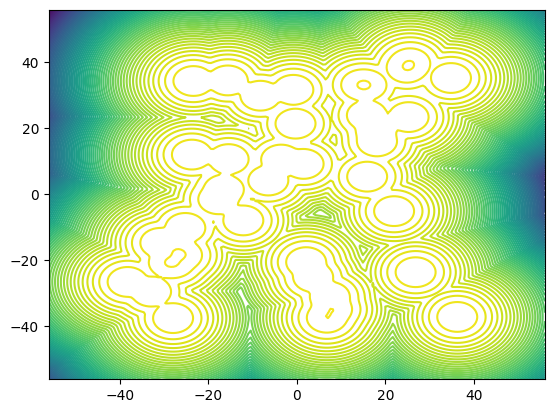

In [4]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

if device == "cpu":
    use_gpu = False
else:
    use_gpu = True
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=use_gpu, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to(device)

### Helper Functions

In [5]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)

    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")
    else:
        #delete subplot
        fig.delaxes(axs[1])
        
    target.to(device)
    plt.show()
    return [fig]

In [6]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    # mins = -1 
    # maxs = 1
    mins = -50
    maxs = 50 
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

## Function Definitions

### Estimated Reward Functions

In [7]:
def var_schedule(beta, t):
    return beta * t # **2

def diffusion_coeff(beta, t):
    return beta #* 2 * t

In [8]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = var_schedule(beta, repeated_t)
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [9]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, 
                      randomness='different', in_dims=(0,0,None,None))(x, t, beta, 
                                                                       num_mc_samples, var_exploding=var_exploding)

In [10]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=200, var_exploding=True, richardson=False):
    est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
                            in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
                                                                                  var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
                                   in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

### True Reward Functions

In [11]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = var_schedule(beta, t) # beta * t
    target.convolve(h_t * (global_maxs **2), t, var_exploding=var_exploding)
    # target.convolve(h_t , t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    # energy = target.log_prob(x)
    target.reset()
    return energy

In [12]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    samples_energy = true_Rt(x, t[0], beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

## SDE Tests

### Dataset

In [13]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/torch/_tensor.py:738: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1992.)
  LU, pivots, infos = torch._lu_with_info(


In [14]:
# normalize the dataset
init_num_samples = 2048
unnorm_true_samples = target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
unnorm_init_samples = flow.sample((init_num_samples,)).to(device).detach()
init_energy = target.log_prob(unnorm_init_samples).detach()
init_samples = normalize(unnorm_init_samples)

global_mins_init = -50
global_maxs_init = 50

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size = 512, shuffle=True) 

In [15]:
true_samples = normalize(unnorm_true_samples)
true_energy = target.log_prob(unnorm_true_samples).detach()

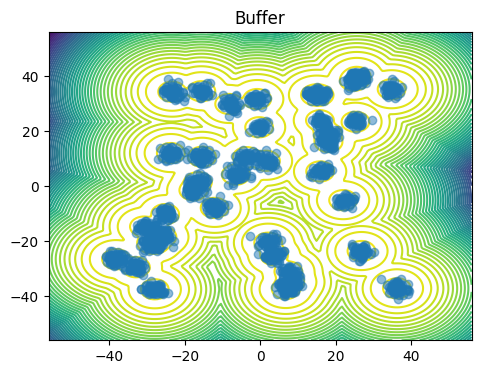

In [16]:
plot_dataset(unnormalize(true_samples, -50, 50)) # visualise the initial samples
plt.show()

### VE SDE

In [17]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            x.requires_grad = True
            # score = self.score(x, 1-t, self.beta)
            score = self.score(torch.cat([x, 1-t.unsqueeze(1)], dim=1))
        return self.g(t, x)**2 * score 
    
    def g(self, t, x):
        return diffusion_coeff(self.beta, t.unsqueeze(1)) ** 0.5
        # return torch.full_like(x, self.beta ** 0.5)

In [18]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500).to(device)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
    return samples

In [20]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    pred_v = []
    true_v = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            pred_v.append(f)
    return torch.stack(samples), torch.stack(pred_v)

### SDE Tests

In [21]:
num_samples = 1000
beta = 0.5

with torch.no_grad():
    target.convolve(torch.tensor(beta*50**2, device=torch.device('cpu')), 1)
    x1_samples = target.sample((num_samples,))
    target.reset()
    x1_samples_normalized = normalize(x1_samples)

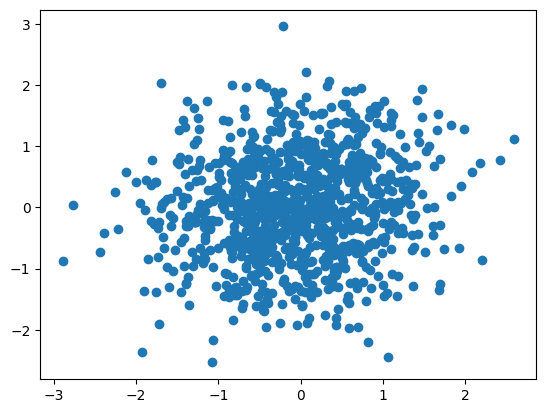

In [22]:
plt.plot(x1_samples_normalized[:,0].cpu(), x1_samples_normalized[:,1].cpu(), 'o')

In [ ]:
# ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)
# samples = generate_samples(ve_reverse_sde, x1_samples_normalized)
samples, pred_vectors = integrate_sde(ve_reverse_sde, x1_samples_normalized, [0, 1], 0.001) #true_vectors

In [ ]:
plot_dataset(unnormalize(samples[-1], global_mins_init, global_maxs_init))

In [ ]:
plt.plot(torch.arange(0, 1, 0.001), samples[:, :100, 0].detach().cpu())
plt.xlabel('time')
plt.show()

In [ ]:
ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
# samples = generate_samples(ve_reverse_sde, x1_samples_normalized)
true_samples, true_vectors = integrate_sde(ve_reverse_sde, x1_samples_normalized, [0, 1], 0.001) #true_vectors

NameError: name 'pred_vectors' is not defined

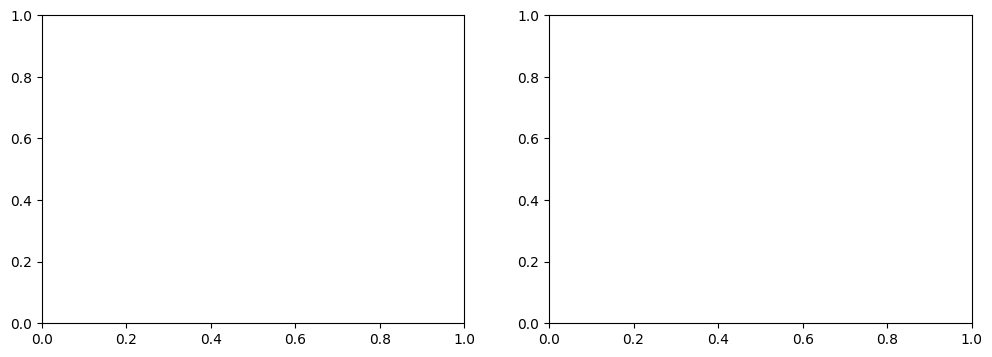

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# predicted 
traj_pred = torch.cumsum(pred_vectors, dim=-1)
axs[0].plot(torch.arange(0, 1, 0.001), torch.linalg.norm(traj_pred[:,:200], dim=-1).cpu())
axs[0].set_xlabel("time")
axs[0].set_title(r"Trajectory following the predicted $\nabla \log E[R(x)]$")


# true
traj_true = torch.cumsum(true_vectors, dim=-1)
axs[1].plot(torch.arange(0, 1, 0.001), torch.linalg.norm(traj_true[:,:200], dim=-1).cpu())
axs[1].set_xlabel("time")
axs[1].set_title(r"Trajectory following the predicted $\nabla \log R(x)$")

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# predicted 
# plt.plot(torch.arange(0, 1, 0.001), torch.cumsum(traj_norm_pred, dim=0).cpu())
axs[0].plot(torch.arange(0, 1, 0.001), torch.cumsum(pred_vectors[:, :100, 0], dim=0).cpu())
axs[0].set_xlabel("time")
axs[0].set_title(r"Trajectory following the predicted $\nabla \log E[R(x)]$")


# true
# plt.plot(torch.arange(0, 1, 0.001), torch.cumsum(traj_norm_true, dim=0).cpu())
axs[1].plot(torch.arange(0, 1, 0.001), torch.cumsum(true_vectors[:, :100, 0], dim=0).cpu())
axs[1].set_xlabel("time")
axs[1].set_title(r"Trajectory following the true $\nabla \log R(x)$")

plt.show()

In [27]:
for i in range(0, samples.shape[0], 199):
    plot_dataset(unnormalize(samples[i], global_mins_init, global_maxs_init))

NameError: name 'samples' is not defined

### Training

In [28]:
def cfm_inference(model, xt, t, dt):
    with torch.no_grad():
        # vt = model(xt, t * torch.ones(xt.shape[0]).to(device))
        vt = model(torch.cat([xt, (t * torch.ones(xt.shape[0]).to(device)).unsqueeze(1)], dim=-1))
        xt_new = xt + vt * dt
        return xt_new

In [21]:
def generate_samples_ode(model, x_init, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    samples = []
    x = x_init
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, 1e-3)
            samples.append(x)
    return torch.stack(samples)

In [22]:
def score_loss(vectorfield, x, t, beta):
    h_t = beta * t.unsqueeze(1)
    # x(t)
    x_t = torch.normal(x, h_t ** 0.5)
    # s_pred = vectorfield(x_t, t)
    s_pred = vectorfield(torch.cat([x_t, t.unsqueeze(1)], dim=-1))

    s_true = - (x_t - x)/ (h_t + 1e-3)
    
    lambda_t = 1 /(h_t + 1e-3)
    s_diff = lambda_t * torch.linalg.vector_norm(s_pred - s_true, dim=-1) ** 2
    return s_diff.mean()    

In [23]:
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from models.mlp import MyMLPCFM
FM = ConditionalFlowMatcher(sigma=0.0)

In [24]:
def cfm_loss(model, x1, beta):
    x0 = torch.randn(batch_size, dim).to(device) * np.sqrt(beta)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    # vt = model(xt, t)
    vt = model(torch.cat([xt, t.unsqueeze(1)], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    return loss

In [103]:
beta = 0.5
# beta = 0.5 * 50**2
batch_size = 256
# vectorfield = MyMLP().to(device)
vectorfield = MyMLPCFM().to(device)
opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-3)

Epoch 5000 | Loss 0.493341


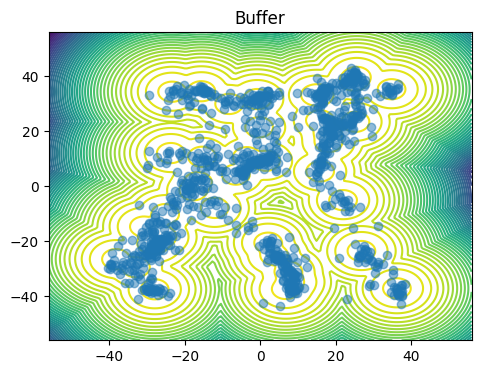

Epoch 10000 | Loss 0.466068


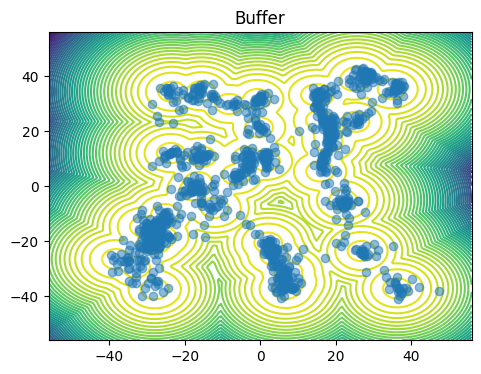

Epoch 15000 | Loss 0.517079


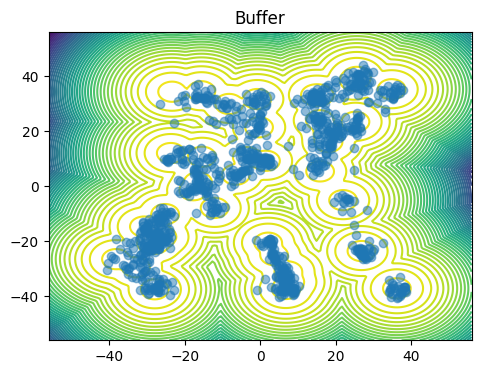

Epoch 20000 | Loss 0.450347


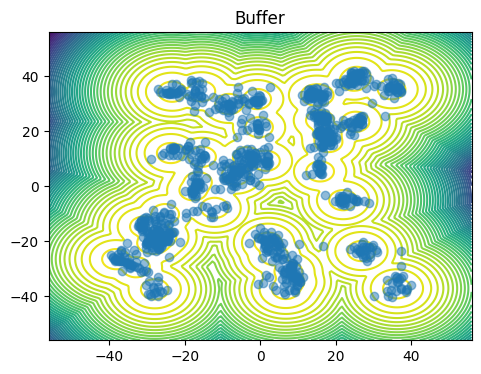

Epoch 25000 | Loss 0.466797


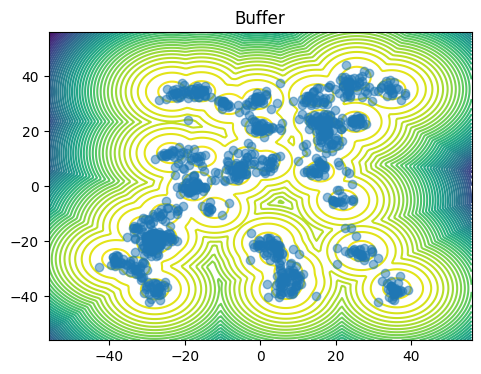

Epoch 30000 | Loss 0.429197


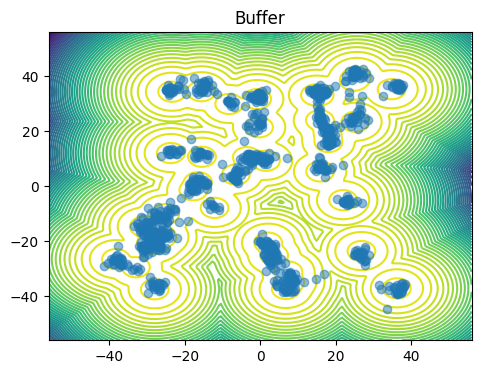

In [104]:
for k in range(30000):
    perm = torch.randperm(unnorm_true_samples.shape[0])
    idx = perm[:batch_size]
    # x0 = unnorm_true_samples[idx]
    x0 = true_samples[idx]
    
    opt_vectorfield.zero_grad()

    t = torch.rand(len(x0), device=device)

    loss = cfm_loss(vectorfield, x0, beta) 
    # loss = score_loss(vectorfield, x0, t, beta)

    loss.backward()
    opt_vectorfield.step()

    if (k + 1) % 5000 == 0:
        print("Epoch %d | Loss %f" % (k+1, loss.item()))

        # Generate samples using the network
        ve_reverse_sde = VEReverseSDE(vectorfield, beta)
        x1_samples = (torch.randn((1024, dim), device=device) * np.sqrt(beta)).to(device)
        # samples, _ = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 0.01)
        # samples = samples[-1]
        samples = generate_samples_ode(vectorfield, x1_samples, [0, 1], 1e-3)[-1]
        
        plot_dataset(unnormalize(samples, -50, 50))
        # plot_dataset(samples)
        plt.show()

### Evaluation

In [ ]:
samples,_ = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 0.001)
samples = samples[-1]
plot_dataset(unnormalize(samples, -50, 50))

In [34]:
follow_estimate = False
follow_true = False
follow_model = True

In [40]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = -0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            #print(norm.max())
            max_norm = 200
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f * clip_coef.unsqueeze(-1)
        elif follow_true:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        elif follow_model:
            f = - 0.5 * beta * vectorfield(torch.cat([x, t.unsqueeze(1)], dim=-1))
            norm = torch.linalg.vector_norm(f, dim=-1)
            # print("norm", norm.max())
            max_norm = 100
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f  #* clip_coef.unsqueeze(-1)
            # print("clipped norm", torch.linalg.vector_norm(f, dim=-1).max())
    return f

In [41]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    def log_change_of_variables(x):
        return torch.trace(J(x.unsqueeze(0)).squeeze())
    return log_change_of_variables

def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    elif follow_true:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    elif follow_model:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    return dx, div

In [42]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(2).to(device), torch.eye(2).to(device) * beta
    )
    return dist

In [43]:
reverse_time = False

In [50]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    if follow_model:
        def vecfield(x):
            return drift(x, torch.ones(x.shape[0]).to(device) * t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 2).to(device) * np.sqrt(beta)
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        x1 = true_samples
        time = torch.linspace(0, 1, 1000).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

In [118]:
x0_unnorm = unnormalize(x0, -50, 50)
prior_dist_unnorm = prior_dist(beta *50**2 )
logp0_unnorm = prior_dist_unnorm.log_prob(x0_unnorm)

In [120]:
- (logp0_unnorm + logdetjac).mean()

tensor(7.2745, device='cuda:0')

In [51]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-2.0208, device='cuda:0')
logdetjac tensor(2.2591, device='cuda:0')
logp1 tensor(-0.2383, device='cuda:0')


In [116]:
p0 = prior_dist(beta)
prior_samples = p0.sample((1024,)).to(device)

log_p0_true_1 = true_Rt(prior_samples, torch.tensor(1).to(device), beta)
log_p0_true = p0.log_prob(prior_samples)
print("logp0 true: ", log_p0_true.mean())
print("logp0 true: ", log_p0_true_1.mean())

logp0 true:  tensor(-2.1388, device='cuda:0')
logp0 true:  tensor(-10.0321, device='cuda:0')


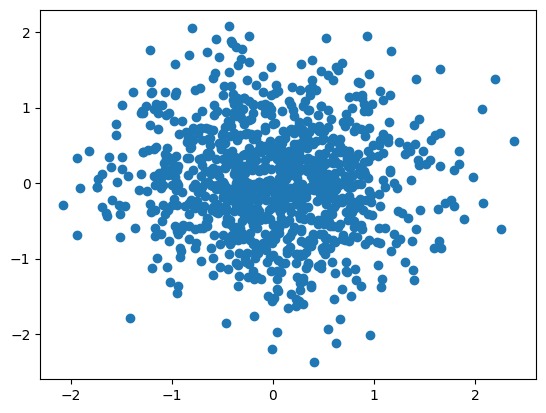

In [111]:
plt.scatter(prior_samples[:, 0].cpu(), prior_samples[:, 1].cpu(), label="prior")

In [86]:
def get_likelihoods(test_data):
    with torch.no_grad():
        x0 = node.trajectory(
            torch.cat(
                [
                    torch.zeros((test_data.shape[0], 1)).to(device),
                    test_data.reshape(-1, 2),
                ],
                dim=1,
            ),
            t_span=torch.linspace(1, 0, 101).to(device),
        )
        # print(x0[:, :, 0])
        log_change_of_variables = x0[-1, :, 0]

        x0 = x0[-1, :, 1:].reshape(-1, dim)

        prior_prob = dist.log_prob(x0)
        log_prob_x1 = prior_prob - log_change_of_variables
        nll = -(prior_prob - log_change_of_variables)
        print(
            prior_prob.mean(),
            log_change_of_variables.mean(),
            log_prob_x1.mean(),
            nll.mean(),
        )
        return log_prob_x1, x0

In [88]:
amodel = AugmentedVectorField(torch_wrapper(vectorfield), [CNFReg("exact")], dim=(2,))


dist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device)* beta)

node = NeuralODE(amodel, solver="euler")
p_data, x0 = get_likelihoods(true_samples)

tensor(-1.3452, device='cuda:0') tensor(-2.0674, device='cuda:0') tensor(0.7222, device='cuda:0') tensor(-0.7222, device='cuda:0')


In [106]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    model = lambda x: torch_wrapper(vectorfield)(t, x)
    dx, div = output_and_div(model, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


with torch.no_grad():
    x1 = true_samples #unnorm_true_samples #
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1]).to(device)], dim=-1)
    state1.requires_grad = True
    state0 = odeint(
        odefunc, state1, t=torch.linspace(1, 0, 1000).to(device), method="euler"
    )[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]

In [107]:
p0 = prior_dist(beta)
prior_samples = p0.sample((1024,)).to(device)

logp0 = p0.log_prob(x0)
logp1 = -(logp0 + logdetjac)
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-2.0514, device='cuda:0')
logdetjac tensor(2.6009, device='cuda:0')
logp1 tensor(-0.5495, device='cuda:0')


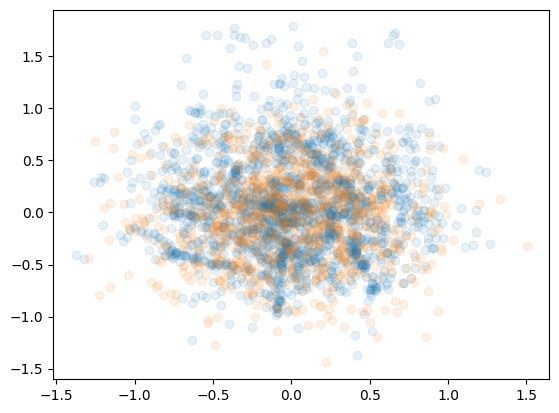

In [66]:
plt.scatter(x0[:, 0].detach().cpu(), x0[:, 1].detach().cpu(), alpha=0.1, label="x0")
plt.scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.1, label="prior")

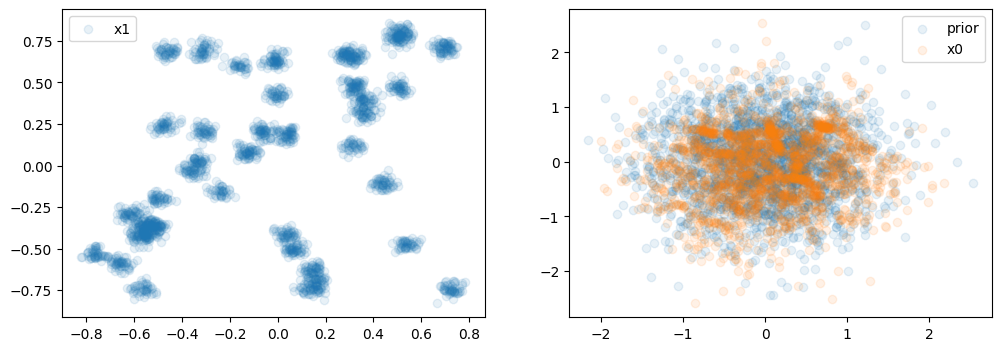

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x1[:, 0].detach().cpu(), x1[:, 1].detach().cpu(), alpha=0.1, label="x1")

prior_samples = p0.sample((2048,))
if reverse_time:
    ax[0].scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.2, label="prior")
    ax[1].scatter(samples[:, 0].detach().cpu(), samples[:, 1].detach().cpu(), alpha=0.1, label="generated samples")
else:
    ax[1].scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.1, label="prior")
ax[0].legend()

ax[1].scatter(x0[:, 0].detach().cpu(), x0[:, 1].detach().cpu(), alpha=0.1, label="x0")
ax[1].legend()
# plt.xlim(0.1, 0.3)
# plt.ylim(-0.5, 0.5)
# plt.ylim(-2, 2)
# plt.xlim(-2, 2)
plt.show()